## <u><b>시계열 데이터 예측하기 - 다변량 시계열 데이터 예측하기
<b> 참고: https://bit.ly/3XROcBy
> <b> 표준화(Standardization) <br/>
    한 스탭 예측(Single step model) <br/>

각 시간 단위마다 여러 개의 값을 가지는 데이터를 <b>다변량 시계열 데이터 (Multivariate Time Series Data)</b>라고 한다.<br/>
시간 단위는 시 (hour), 분 (minute), 초 (second) 또는 월 (month), 연도 (year) 등 다양한 단위를 가질 수 있다.<br/>
해당 날씨 데이터셋은 14개의 날씨 속성을 갖고 있다.<br/>
아래 예제에서는 문제를 간단하게 하게 위해 14개 중 <b>온도 (air temperature), 기압 (atmospheric pressure), 공기밀도 (air density)</b> 데이터 세가지 속성을 다룬다.

In [31]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [32]:
df = pd.read_csv('./Data/jena_climate_2009_2016.csv')

features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
print(features.head())

                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
01.01.2009 00:10:00    996.52     -8.02       1307.75
01.01.2009 00:20:00    996.57     -8.41       1309.80
01.01.2009 00:30:00    996.53     -8.51       1310.24
01.01.2009 00:40:00    996.51     -8.31       1309.19
01.01.2009 00:50:00    996.51     -8.27       1309.00


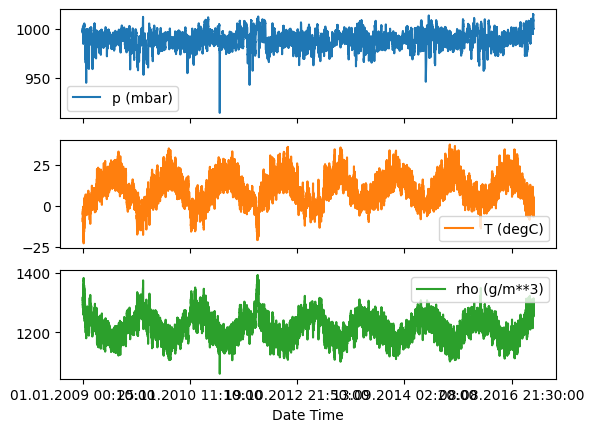

In [33]:
features.plot(subplots=True)
plt.show()

### <b>표준화(Standardization)

In [34]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std
print(dataset)

[[ 0.95547359 -1.99766294  2.2350791 ]
 [ 0.96154485 -2.04281897  2.28524007]
 [ 0.95668784 -2.05439744  2.29600633]
 ...
 [ 1.35617678 -1.43494935  1.76136375]
 [ 1.35496252 -1.55883897  1.88786728]
 [ 1.35617678 -1.62715193  1.95686921]]


### <b>한 스탭 예측(Single step model)

이제 신경망 모델은 주어진 과거의 자료로부터 하나의 포인트를 예측하는 것을 학습한다. <br/>
아래의 `multivariate_data` 함수는 이전의 `univariate_data` 함수와 비슷하게 동작하지만 step 값이 주어진다면 step에 맞게 데이터를 샘플링한다.

In [35]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [36]:
past_history = 720 # 지난 5일간의 데이터 -> 5일 * 144개, 144 = 6*24시간
future_target = 72 # 72시간 스탭 이후를 예측
STEP = 6 # 샘플링 간격 

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history,
                                                   future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history,
                                               future_target, STEP, single_step=True)

print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


2023-01-31 17:47:14.254570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-31 17:47:14.301589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 35ms/step
(256, 1)
Epoch 1/10


2023-01-31 17:47:15.520179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-31 17:47:15.695225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-31 17:47:15.999787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 0.3251

2023-01-31 17:47:28.250157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-31 17:47:28.299975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 15s 68ms/step - loss: 0.3251 - val_loss: 0.2670
Epoch 2/10
200/200 [==============================] - 13s 63ms/step - loss: 0.2656 - val_loss: 0.2596
Epoch 3/10
200/200 [==============================] - 12s 61ms/step - loss: 0.2618 - val_loss: 0.2514
Epoch 4/10
200/200 [==============================] - 12s 62ms/step - loss: 0.2603 - val_loss: 0.2485
Epoch 5/10
200/200 [==============================] - 13s 63ms/step - loss: 0.2284 - val_loss: 0.2396
Epoch 6/10
200/200 [==============================] - 13s 63ms/step - loss: 0.2411 - val_loss: 0.2629
Epoch 7/10
200/200 [==============================] - 12s 62ms/step - loss: 0.2441 - val_loss: 0.2602
Epoch 8/10
200/200 [==============================] - 13s 63ms/step - loss: 0.2430 - val_loss: 0.2425
Epoch 9/10
200/200 [==============================] - 12s 62ms/step - loss: 0.2468 - val_loss: 0.2454
Epoch 10/10
200/200 [==============================] - 12s 62ms/step - loss: 0.2426 - val_los

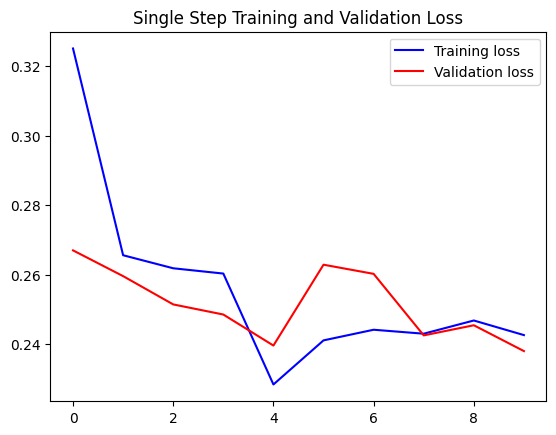

In [37]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 10

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

# 학습 과정 그래프 시각화
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and Validation Loss')

In [40]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

8/8 [==============================] - 0s 16ms/step


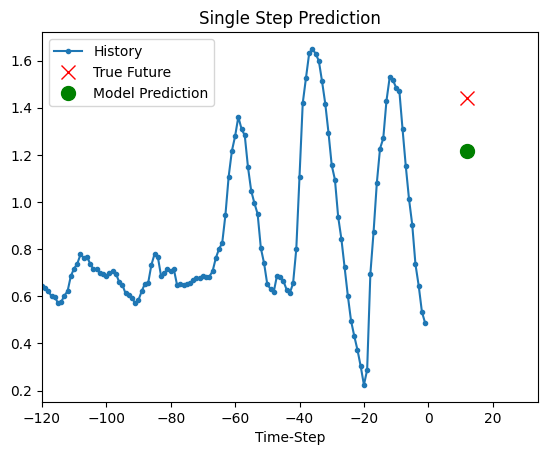

8/8 [==============================] - 0s 15ms/step


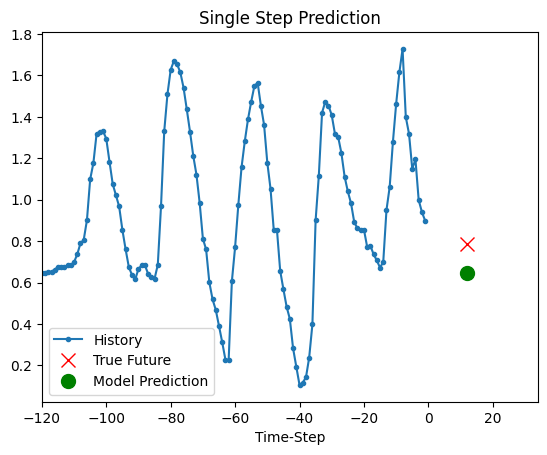

8/8 [==============================] - 0s 15ms/step


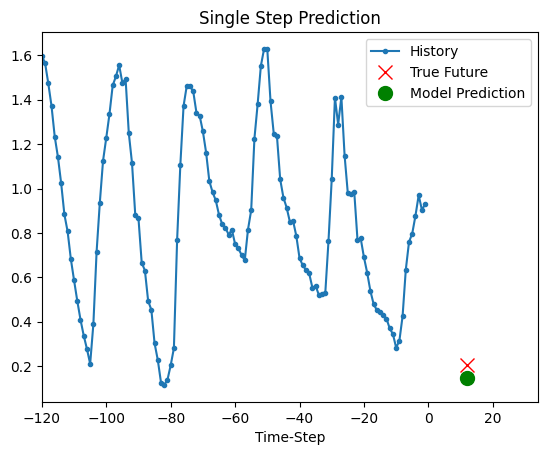

In [41]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                      single_step_model.predict(x)[0]], 12,
                     'Single Step Prediction')
    plot.show()

In [42]:
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history, future_target, STEP)

print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)
